In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
import scienceplots

plt.style.use('science')

from lmfit import Parameters
from lmfit import minimize, fit_report

In [2]:
import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal
from pyroll.freiberg_flow_stress import flow_stress

In [3]:
from in_profile import create_in_profile_for_finishing_train
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3
from utilities import *

In [4]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

root_dir = Path.cwd()
result_dir = root_dir / "res"

In [5]:
@pr.CoolingPipe.DiskElement.heat_transfer_coefficient
def heat_transfer_coefficient_model_wehage_8_mm(self: pr.CoolingPipe.DiskElement):
    mean_surface_temperature = (self.in_profile.surface_temperature + self.out_profile.surface_temperature) / 2
    profile_surface_temperature_celsius = mean_surface_temperature - 273.15
    return 13950 + 5.12 * 1e6 / profile_surface_temperature_celsius

In [6]:
in_profile = create_in_profile_for_finishing_train(1000 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [7]:
rolling_train_rpd1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [8]:
rolling_train_rpd1.solve(in_profile)
rolling_train_rpd2.solve(in_profile)
rolling_train_rpd3.solve(in_profile)

Solution iteration of TwoRollPass '23-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '24-V' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '17-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '21-H' exceeded the maximum iteration count of 100. Continuing anyway.


Profile(
    classifiers={'false_round', 'generic_elongation', 'round', 'symmetric'},
    core_temperature=np.float64(1427.6761988519434),
    cross_section=Polygon(
        area=5.82635223011719e-05,
        height=0.008700000000000006,
        perimeter=0.027129052534426306,
        width=0.008249205309779701,
        ),
    length=92.57471047202144,
    material=['BST500', 'steel'],
    ring_temperatures=array([1427.67619885, 1425.12885076, 1417.48364213, 1404.71390799,
           1386.73283377, 1363.43020677, 1334.96919828, 1302.52868241,
           1269.31990663, 1240.94291809, 1223.47281019]),
    strain=np.float64(0.429279759512508),
    surface_temperature=np.float64(1223.4728101860087),
    t=np.float64(1.8404522810135255),
    temperature=np.float64(1300.7235075758595),
    weight=2400,
    width=np.float64(0.008249205309779701),
    )

In [9]:
sequences = [
    {"label": "RPD1", "sequence": rolling_train_rpd1},
    {"label": "RPD2", "sequence": rolling_train_rpd2},
    {"label": "RPD3", "sequence": rolling_train_rpd3}
]

In [10]:
params_constant = Parameters()
params_constant.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_4_pass_block = Parameters()
params_4_pass_block.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_6_pass_block = Parameters()
params_6_pass_block.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_csb_block = Parameters()
params_csb_block.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_clusters = Parameters()
params_clusters.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

In [11]:
result_constant = minimize(
    solve_total_wear_depths_as_contour_line,
    params_constant,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="nelder"
)

RMS error:  0.2420484955452572
RMS error:  2.0028916613758163
RMS error:  5.752653915222318
RMS error:  0.21317566821965148
RMS error:  2.0028916613758163
RMS error:  0.00022711748822460534
RMS error:  0.2420484955452572
RMS error:  0.04985614446633084
RMS error:  0.06429323625979921
RMS error:  0.0108297755441012
RMS error:  0.01804840617909811
RMS error:  0.0019754501950541205
RMS error:  0.005584775800408501
RMS error:  0.00021303589311117332
RMS error:  0.0019754501950541205
RMS error:  2.4920020484962205e-06
RMS error:  0.00022711748822460534
RMS error:  5.002636569365573e-05
RMS error:  5.7064475999604446e-05
RMS error:  1.023650411805695e-05
RMS error:  1.3729640266429707e-05
RMS error:  1.7111532353284848e-06
RMS error:  1.7111532353284848e-06
RMS error:  1.7111532353284848e-06
RMS error:  8.923955915773762e-06
RMS error:  4.083500503209105e-05


In [12]:
print(fit_report(result_constant))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 22
    # data points      = 103
    # variables        = 1
    chi-square         = 3.0159e-10
    reduced chi-square = 2.9568e-12
    Akaike info crit   = -2733.33866
    Bayesian info crit = -2730.70393
[[Variables]]
    wear_coefficient:  1.0929e-10 +/- 3.7966e-12 (3.47%) (init = 1e-05)


In [13]:
result_4_pass_block = minimize(
    solve_total_wear_depths_as_contour_line_4_pass_block,
    params_4_pass_block,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="cobyla"
)

RMS error:  0.26281807549007735
RMS error:  626.341967587699
RMS error:  582.113324921724
RMS error:  148.49900839778047
RMS error:  47.60853746567712
RMS error:  7.23723972878279
RMS error:  4.469523273248688
RMS error:  0.08315108152430353
RMS error:  0.47452128592954945
RMS error:  0.007761838430073586
RMS error:  0.00014400005384344652
RMS error:  0.003854373867160277
RMS error:  0.00016863625148084022
RMS error:  0.000601636272487807
RMS error:  3.268338094978066e-05
RMS error:  7.997141433925887e-07
RMS error:  8.815432676616672e-06
RMS error:  3.820528179924588e-06
RMS error:  3.820528179924588e-06
RMS error:  3.820528179924588e-06
RMS error:  5.123913417655554e-05
RMS error:  8.815432676616672e-06


In [14]:
print(fit_report(result_4_pass_block))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 18
    # data points      = 25
    # variables        = 1
    chi-square         = 3.6491e-10
    reduced chi-square = 1.5205e-11
    Akaike info crit   = -621.756094
    Bayesian info crit = -620.537218
[[Variables]]
    wear_coefficient:  1.6322e-10 +/- 1.7234e-11 (10.56%) (init = 1e-05)


In [15]:
result_6_pass_block = minimize(
    solve_total_wear_depths_as_contour_line_6_pass_block,
    params_6_pass_block,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="nelder"
)

RMS error:  0.2760120100464897
RMS error:  2.283936352105553
RMS error:  6.55986452818205
RMS error:  0.2430877531129015
RMS error:  2.283936352105553
RMS error:  0.00025830027185850813
RMS error:  0.2760120100464897
RMS error:  0.05685126501810936
RMS error:  0.07331416677268357
RMS error:  0.012348723440066302
RMS error:  0.02058027096207529
RMS error:  0.0022519606698741894
RMS error:  0.00636774629596872
RMS error:  0.00024224260485858934
RMS error:  0.0022519606698741894
RMS error:  3.2612067450810403e-06
RMS error:  0.00025830027185850813
RMS error:  5.635164631275329e-05
RMS error:  6.437876110481196e-05
RMS error:  1.0939471298425274e-05
RMS error:  1.493393665521815e-05
RMS error:  1.5840719313614863e-06
RMS error:  1.5840719313614863e-06
RMS error:  1.5840719313614863e-06
RMS error:  9.436781141914674e-06
RMS error:  4.58680988001627e-05


In [16]:
print(fit_report(result_6_pass_block))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 22
    # data points      = 52
    # variables        = 1
    chi-square         = 1.3048e-10
    reduced chi-square = 2.5585e-12
    Akaike info crit   = -1386.97323
    Bayesian info crit = -1385.02199
[[Variables]]
    wear_coefficient:  1.0929e-10 +/- 4.4342e-12 (4.06%) (init = 1e-05)


In [17]:
result_csb_block = minimize(
    solve_total_wear_depths_as_contour_line_csb_block,
    params_csb_block,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="nelder"
)

RMS error:  0.11538890397539626
RMS error:  0.9548171297611283
RMS error:  2.742401814728271
RMS error:  0.10162466495317163
RMS error:  0.9548171297611283
RMS error:  0.00010794592057042567
RMS error:  0.11538890397539626
RMS error:  0.02376706768698403
RMS error:  0.030649510475189535
RMS error:  0.005162437684238746
RMS error:  0.008603699466508276
RMS error:  0.0009414085247974667
RMS error:  0.0026620441915384155
RMS error:  0.00010123306003900376
RMS error:  0.0009414085247974667
RMS error:  1.5994917011643654e-06
RMS error:  0.00010794592057042567
RMS error:  2.3528560077798788e-05
RMS error:  2.688296417219248e-05
RMS error:  4.587654372138412e-06
RMS error:  6.242817714598981e-06
RMS error:  9.172190724454813e-07
RMS error:  9.172190724454813e-07
RMS error:  9.172190724454813e-07
RMS error:  3.967748342415484e-06
RMS error:  1.914837444735776e-05


In [18]:
print(fit_report(result_csb_block))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 22
    # data points      = 26
    # variables        = 1
    chi-square         = 2.1874e-11
    reduced chi-square = 8.7494e-13
    Akaike info crit   = -720.899814
    Bayesian info crit = -719.641717
[[Variables]]
    wear_coefficient:  1.0929e-10 +/- 8.7910e-12 (8.04%) (init = 1e-05)


In [19]:
result_clusters = minimize(
    solve_total_wear_depths_as_contour_line_4_and_6_pass_block,
    params_clusters,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="nelder"
)

In [20]:
print(fit_report(result_clusters))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 22
    # data points      = 77
    # variables        = 1
    chi-square         = 2.7972e-10
    reduced chi-square = 3.6805e-12
    Akaike info crit   = -2026.26123
    Bayesian info crit = -2023.91742
[[Variables]]
    wear_coefficient:  1.0929e-10 +/- 4.3578e-12 (3.99%) (init = 1e-05)


In [21]:
measured_wear_area_constant = []
calculated_wear_area_constant = []

measured_wear_area_4_pass = []
calculated_wear_area_4_pass = []

measured_wear_area_6_pass = []
calculated_wear_area_6_pass = []

measured_wear_area_csb = []
calculated_wear_area_csb = []

measured_wear_area_4_and_6_pass = []
calculated_wear_area_4_and_6_pass = []

In [22]:
for entry in sequences:
    groove_label = entry["label"]
    sequence = entry["sequence"]
    roll_passes = sequence.roll_passes
    measurements = extract_wear_contours_from_measurement(groove_label)
    for measurement_id, labels, tonnages, measured_wear_contours in measurements:
        for roll_pass in roll_passes:
            for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                if roll_pass.label == label:
                    calculated_wear_contour = calculate_wear_contour(roll_pass, result_constant.params['wear_coefficient'].value, tonnage * 1000)
                    calculated_wear_area_constant.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                    measured_wear_area_constant.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    if roll_pass.label in ["17-H", "18-V"]:
                        calculated_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                        measured_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    elif roll_pass.label in ["21-H", "22-V", "23-H", "24-V"]:
                         calculated_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    elif roll_pass.label in ["27-H", "28-V"]:
                         calculated_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))

for entry in sequences:
    groove_label = entry["label"]
    sequence = entry["sequence"]
    roll_passes = sequence.roll_passes
    measurements = extract_wear_contours_from_measurement(groove_label)
    for measurement_id, labels, tonnages, measured_wear_contours in measurements:
        for roll_pass in roll_passes:
            for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                if roll_pass.label == label:
                    if roll_pass.label in ["17-H", "18-V", "21-H", "22-V", "23-H", "24-V"]:
                        calculated_wear_contour = calculate_wear_contour(roll_pass, result_clusters.params['wear_coefficient'].value, tonnage * 1000)
                        calculated_wear_area_4_and_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                        measured_wear_area_4_and_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))


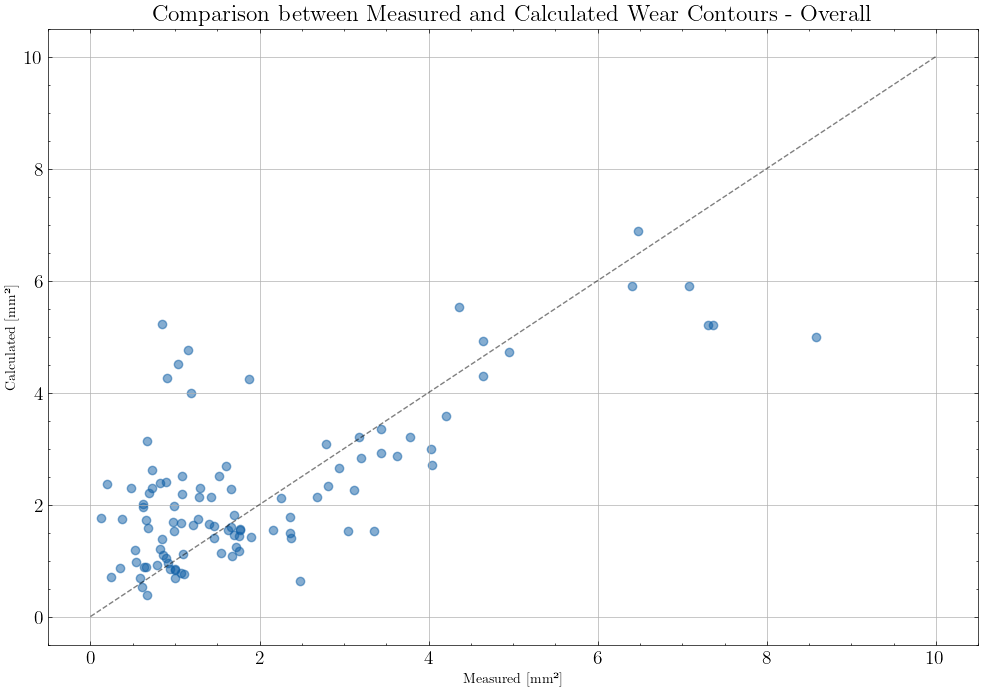

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours - Overall")
ax.scatter(np.array(measured_wear_area_constant) * 1e6, np.array(calculated_wear_area_constant) * 1e6, color='C0', alpha=0.5)
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]", fontsize=10)
ax.set_xlabel("Measured [mm²]", fontsize=10)

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_overall.pdf", bbox_inches='tight', dpi=300)

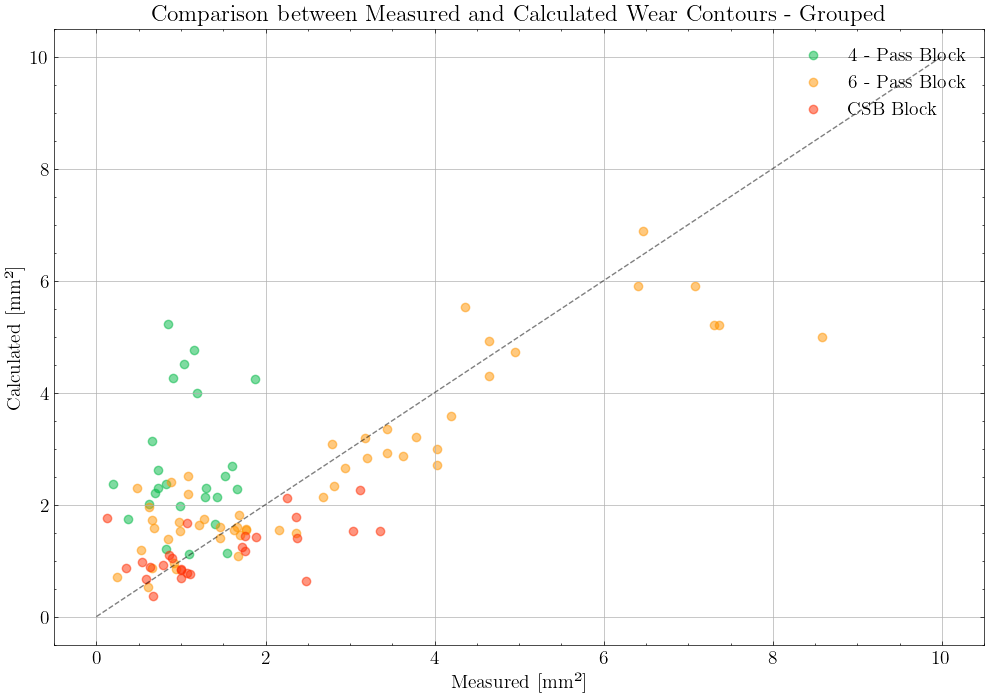

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours - Grouped")
ax.scatter(np.array(measured_wear_area_4_pass) * 1e6, np.array(calculated_wear_area_4_pass) * 1e6, color='C1', alpha=0.5, label="4 - Pass Block")
ax.scatter(np.array(measured_wear_area_6_pass) * 1e6, np.array(calculated_wear_area_6_pass) * 1e6, color='C2', alpha=0.5, label="6 - Pass Block")
ax.scatter(np.array(measured_wear_area_csb) * 1e6, np.array(calculated_wear_area_csb) * 1e6, color='C3', alpha=0.5, label="CSB Block")
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_per_block.pdf", bbox_inches='tight', dpi=300)

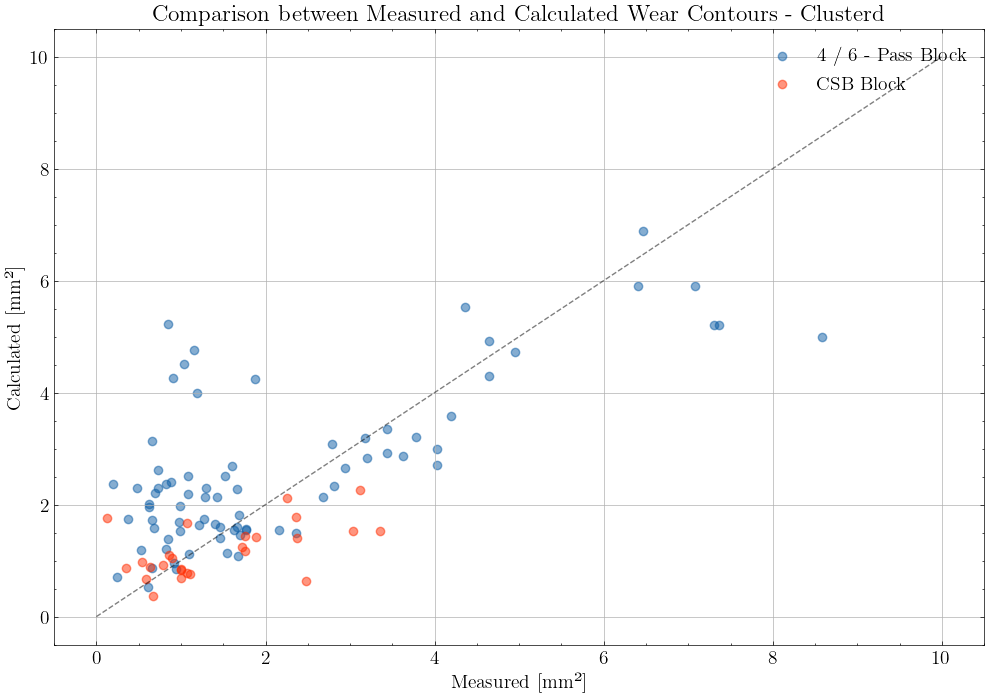

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours - Clusterd")
ax.scatter(np.array(measured_wear_area_4_and_6_pass) * 1e6, np.array(calculated_wear_area_4_and_6_pass) * 1e6, color='C0', alpha=0.5, label="4 / 6 - Pass Block")
ax.scatter(np.array(measured_wear_area_csb) * 1e6, np.array(calculated_wear_area_csb) * 1e6, color='C3', alpha=0.5, label="CSB Block")
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_for_clustering.pdf", bbox_inches='tight', dpi=300)